In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

from scipy import integrate

from amuse.ic.kingmodel import new_king_model
from amuse.units import units
from amuse.units import quantities
from amuse.units import constants
from amuse.units import nbody_system
from tqdm import tqdm


class MilkyWayGalaxy(object):
    def __init__(self,R,Mgal=1.6e10|units.MSun,alpha=1.2,Mb=1.40592e10|units.MSun, Md=8.5608e10|units.MSun, Mh=1.07068e11|units.MSun):
        self.radius=R
        self.mass=Mgal
        self.alpha=alpha
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh
    """
    # R, M, and alpha do not matter when we are using gravity of disk, bulge and halo.
    
    def get_gravity_at_point(self,eps,x,y,z):
        r2=x**2+y**2+z**2
        r=r2**0.5
        m=self.mass*(r/self.radius)**self.alpha  
        fr=constants.G*m/r2
        ax=-fr*x/r
        ay=-fr*y/r
        az=-fr*z/r
        return ax,ay,az
    """
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax = force_bulge*x + force_disk*x  + force_halo*x/r
        ay = force_bulge*y + force_disk*y  + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax, ay, az
    

    def circular_velocity(self, r):  
        m = self.mass*(r/self.radius)**self.alpha  
        vc = (constants.G*m/r)**0.5
        return vc

    
    """
    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        c=constants.G*self.mass/self.radius**self.alpha    
        phi=c/(self.alpha-1)*(r**(self.alpha-1)-self.radius**(self.alpha-1))
        return phi
    """
    
    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +np.log(c) + 1.02/(1+d1**1.02) \
                           - np.log(1.0 +d1**1.02) )
        return 2*(pot_bulge + pot_disk + pot_halo) # multiply by 2 because it is a rigid potential

In [2]:
#import astropy.units as u
#import astropy.coordinates as coord
#c = coord.SkyCoord(ra=[158.3122] * u.degree,dec=[-17.3] * u.degree,distance=[11.5] * u.kpc,frame='icrs')
#c.transform_to(coord.Galactocentric)

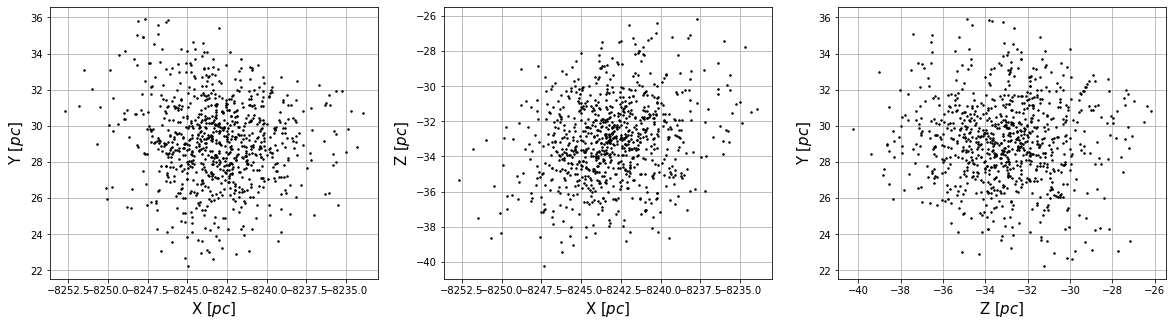

In [3]:
import astropy.units as u
import astropy.coordinates as coord

cluster = pd.read_csv('./pleiades_dbscan.csv')

ra = cluster['ra'] *u.deg
dec = cluster['dec'] *u.deg
distance = 1/cluster['parallax'] *u.pc
pmra = cluster['pmra'] *u.mas/u.yr
pmdec = cluster['pmdec'] *u.mas/u.yr

c = coord.SkyCoord(ra=ra,dec=dec,distance=distance,frame='icrs')
#c.transform_to(coord.Galactocentric)

xm = c.transform_to(coord.Galactocentric).x
ym = c.transform_to(coord.Galactocentric).y
zm = c.transform_to(coord.Galactocentric).z

%matplotlib inline
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(xm, ym,color='black',marker='.',linestyle='None',markersize=3,alpha=1)
plt.xlabel("X $[pc]$", fontsize = 15)
plt.ylabel("Y $[pc]$", fontsize = 15)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(xm, zm,color='black',marker='.',linestyle='None',markersize=3,alpha=1)
plt.xlabel("X $[pc]$", fontsize = 15)
plt.ylabel("Z $[pc]$", fontsize = 15)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(zm, ym,color='black',marker='.',linestyle='None',markersize=3,alpha=1)
plt.xlabel("Z $[pc]$", fontsize = 15)
plt.ylabel("Y $[pc]$", fontsize = 15)#,rotation=0)
plt.grid()
#plt.savefig('./2d.jpg')
plt.show()

# Convert Mg into masses

In [4]:
g_mag = cluster['g'] + 5 - 5*np.log10(1/cluster['parallax'])

def mag_to_mass(MG, L0 = 3.828e26, M0 = 4.83, m0 = 1.989e30, a = 3.5, solar_masses = True):
    L = L0 * 10**(-(MG- M0)/2.5)
    if solar_masses == True:
        return (L/L0)**(1/a)
    else:
        return m0 * (L/L0)**(1/a)
    
m = mag_to_mass(g_mag, solar_masses=True)
print(m.sum())

376.222347443


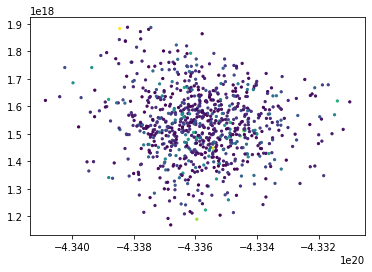

In [5]:
N = len(cluster)
#W0 = 3
#Mcluster = 10.e4 | units.MSun
Rcluster = 7.52335433063542 | units.parsec

alpha_IMF = -2.35
from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(N, 0.1|units.MSun, m.sum()|units.MSun, alpha_IMF)

converter = nbody_system.nbody_to_si(m_stars.sum(),Rcluster)
from amuse.lab import new_plummer_model
bodies = new_plummer_model(N, convert_nbody=converter)

bodies.mass = m_stars
bodies.x = np.array(xm) | units.pc
bodies.y = np.array(ym) | units.pc
bodies.z = np.array(zm) | units.pc
bodies.scale_to_standard(converter)

#print(bodies)
Rgal = 16.2 | units.kpc
Rinit = 8.5 | units.kpc
MWG = MilkyWayGalaxy(Rgal)
#bodies.x += Rinit
bodies.vy = 0.8*MWG.circular_velocity(Rinit)

v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt() # Para el color
s = bodies.mass.value_in(units.MSun)*5 # Para el tamaño
fig = plt.scatter(bodies.x.number, bodies.y.number,s=5, c=v.value_in(units.kms))
plt.show()

# Gravity

In [6]:
from amuse.community.hermite.interface import Hermite
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity_code = Hermite(converter)
gravity_code.particles.add_particles(bodies)
channel = gravity_code.particles.new_channel_to(bodies)

from amuse.couple import bridge
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code,(MWG,) )

timestep=0.1 | units.Myr
endtime = 50 | units.Myr
times = quantities.arange(0|units.Myr, endtime, timestep)

x = [] #| units.parsec
y = [] #| units.parsec
z = [] #| units.parsec
r_virial = [] | units.parsec
mass_ = [] | units.MSun
energy = [] | units.m**2 * units.kg * units.s**-2
kinetic = [] | units.m**2 * units.kg * units.s**-2
potential = [] | units.m**2 * units.kg * units.s**-2
#L = [] | units.parsec

for i in tqdm(times):
    gravity.evolve_model(i)
    channel.copy()
    x.append(gravity.particles.x.value_in(units.parsec))  
    y.append(gravity.particles.y.value_in(units.parsec))
    z.append(gravity.particles.z.value_in(units.parsec))
    r_virial.append(bodies.virial_radius().in_(units.pc))
    mass_.append(bodies.mass.sum().in_(units.MSun))
    energy.append(gravity.potential_energy + gravity.kinetic_energy)
    kinetic.append(gravity.kinetic_energy)
    potential.append(gravity.potential_energy)
    #L.append(LagrangianRadii(bodies))   

gravity.stop()

# Gravity and Stellar

In [11]:
'''
from amuse.community.hermite.interface import Hermite
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii

stellar = SeBa()
stellar.particles.add_particles(bodies)

gravity_code = Hermite(converter)
gravity_code.particles.add_particles(bodies)

from amuse.couple import bridge
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code,(MWG,) )

ch_s2g = stellar.particles.new_channel_to(gravity.particles)
ch_g2l = gravity.particles.new_channel_to(bodies)
ch_s2l = stellar.particles.new_channel_to(bodies)
ch_s2l.copy()

end_time = 50.0 | units.Myr

x = [] #| units.parsec
y = [] #| units.parsec
z = [] #| units.parsec
r_virial = [] | units.parsec
mass_ = [] | units.MSun
energy = [] | units.m**2 * units.kg * units.s**-2
kinetic = [] | units.m**2 * units.kg * units.s**-2
potential = [] | units.m**2 * units.kg * units.s**-2
#L = [] | units.parsec
times = quantities.arange(0|units.Myr, end_time, stellar.particles.time_step.min())

for i in tqdm(times):
    stellar.evolve_model(i)
    ch_s2g.copy()
    ch_s2l.copy()
    gravity.evolve_model(i)
    ch_g2l.copy()
    x.append(gravity.particles.x.value_in(units.parsec))  
    y.append(gravity.particles.y.value_in(units.parsec))
    z.append(gravity.particles.z.value_in(units.parsec))
    r_virial.append(bodies.virial_radius().in_(units.pc))
    mass_.append(bodies.mass.sum().in_(units.MSun))
    energy.append(gravity.potential_energy + gravity.kinetic_energy)
    kinetic.append(gravity.kinetic_energy)
    potential.append(gravity.potential_energy)
    #L.append(LagrangianRadii(bodies))

stellar.stop()
gravity.stop() 
'''

'\nfrom amuse.community.hermite.interface import Hermite\nfrom amuse.community.seba.interface import SeBa\nfrom amuse.ext.LagrangianRadii import LagrangianRadii\n\nstellar = SeBa()\nstellar.particles.add_particles(bodies)\n\ngravity_code = Hermite(converter)\ngravity_code.particles.add_particles(bodies)\n\nfrom amuse.couple import bridge\ngravity = bridge.Bridge(use_threading=False)\ngravity.add_system(gravity_code,(MWG,) )\n\nch_s2g = stellar.particles.new_channel_to(gravity.particles)\nch_g2l = gravity.particles.new_channel_to(bodies)\nch_s2l = stellar.particles.new_channel_to(bodies)\nch_s2l.copy()\n\nend_time = 50.0 | units.Myr\n\nx = [] #| units.parsec\ny = [] #| units.parsec\nz = [] #| units.parsec\nr_virial = [] | units.parsec\nmass_ = [] | units.MSun\nenergy = [] | units.m**2 * units.kg * units.s**-2\nkinetic = [] | units.m**2 * units.kg * units.s**-2\npotential = [] | units.m**2 * units.kg * units.s**-2\n#L = [] | units.parsec\ntimes = quantities.arange(0|units.Myr, end_time, 

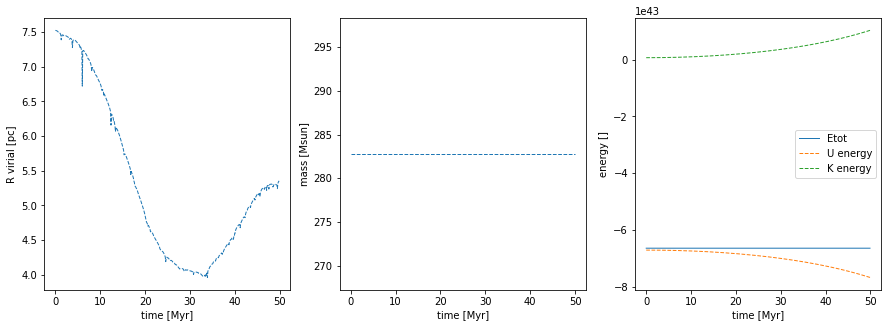

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(times.number, r_virial.number,lw=1, ls='--')
plt.xlabel('time [Myr]')
plt.ylabel('R virial [pc]')

plt.subplot(1,3,2)
plt.plot(times.number, mass_.number,lw=1, ls='--')
plt.xlabel('time [Myr]')
plt.ylabel('mass [Msun]')

plt.subplot(1,3,3)
plt.plot(times.number, energy.number, lw=1, ls='-',label='Etot')
plt.plot(times.number, potential.number, lw=1, ls='--',label='U energy')
plt.plot(times.number, kinetic.number, lw=1, ls='--', label='K energy')
plt.xlabel('time [Myr]')
plt.ylabel('energy []')
#plt.savefig('./evolution_pos,png',bbox_inches='tight')
plt.legend()
plt.show()

Text(0, 0.5, 'z [pc]')

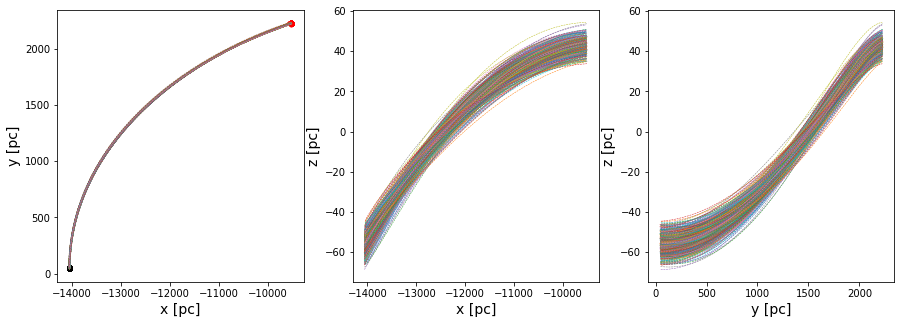

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(x, y, lw=0.5, ls='--')
plt.scatter(x[0], y[0], s=10,color='black')
plt.scatter(x[-1], y[-1], s=10,color='red')
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('y [pc]',fontsize=14)

plt.subplot(1,3,2)
plt.plot(x, z, lw=0.5, ls='--')
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('z [pc]',fontsize=14)

plt.subplot(1,3,3)
plt.plot(y, z, lw=0.5, ls='--')
plt.xlabel('y [pc]',fontsize=14)
plt.ylabel('z [pc]',fontsize=14)
#plt.savefig('./evolution_pos.png',bbox_inches='tight')

Text(0, 0.5, 'y [pc]')

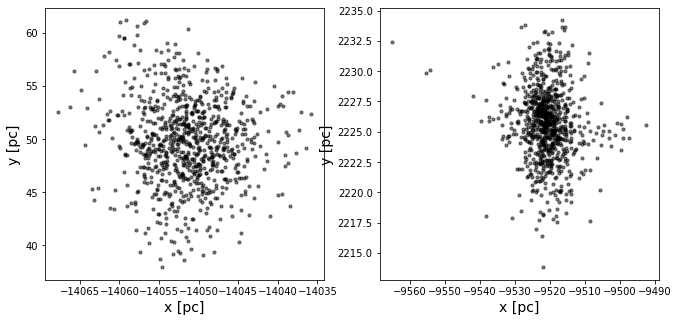

In [10]:
#v = np.log(np.mean((bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()).number)
#print(v)

plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
#plt.scatter(0,0,s=10,color='black')
plt.scatter(x[0], y[0], s=10,alpha=0.5 ,marker='o',color='black')
#plt.arrow(np.mean(x[0]), np.mean(y[0]),-4,0, width = 0.2,color='green')
#plt.arrow(np.mean(x[0]), np.mean(y[0]), v_x0, v_y0, width = 0.2,color='red')
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('y [pc]',fontsize=14)

plt.subplot(1,2,2)
#plt.scatter(0,0,s=10,color='black')
plt.scatter(x[-1], y[-1], s=10,alpha=0.5,marker='o',color='black')
#plt.arrow(np.mean(x[-1]), np.mean(y[-1]), v_xf, v_yf, width = 0.5,color='red')
#plt.arrow(np.mean(x[-1]), np.mean(y[-1]),0,8, width = 0.5,color='green')
#plt.xlim(min(x[-1]), max(x[-1]))
#plt.ylim(min(y[-1]), max(y[-1]))
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('y [pc]',fontsize=14)
#plt.savefig('./evolution_tidal.png',bbox_inches='tight')